# CSTR Reaction Kinetics Example for Embedded GP's

This notebook acts as an example to use FoKL's Embedded GP Methodology to predict multiple GPs in the context of a steady state CSTR.  The preliminary portion of this notebook serves as a problem for the set up of the problem statement for this notebook.

In [1]:
# Import Relevant Libraries

# FoKL for Model Building
from FoKL import Experimental_Embedded_GPs as FoKL_Embedded_GPs

# For Data Manipulation
import pandas as pd
import jax.numpy as jnp
import numpy as np

# For Visualization
import matplotlib.pyplot as plt

ImportError: cannot import name 'Embedded_GPs' from 'FoKL' (c:\Users\Michael\anaconda3\envs\FoKL_HMC\Lib\site-packages\FoKL\__init__.py)

Given the reversible reaction in a liquid CSTR:

\begin{equation}
    A + B \leftrightarrow C
\end{equation}

Knowing the CSTR design equation for component A:

\begin{equation}
    V = \frac{F_{A_{Inlet}} - F_{A_{Outlet}}}{-r_A}
\end{equation}

We can assume elementary reaction kinetics to get the rate of reaction of component A:

\begin{equation}
    -r_{A} = k_{forward} \cdot C_{A} \cdot C_{B} - k_{backwards} \cdot C_{C}
\end{equation}

Assuming the Arrhenius equation applies to the reaction rate kinetics in the form $k = A \exp(-\frac{E_a}{RT})$, we can get the final white box model of:

\begin{equation}
    -r_{A} = \exp(-(k_{f1}\frac{1}{T} + k_{f0})) \cdot C_{A} \cdot C_{B} - \exp(-(k_{b1}\frac{1}{T} + k_{b0})) \cdot C_{C}
\end{equation}

This allows us to explicitly generate temperature dependant reaction rate data for our example.  The goal for this example problem is to solve for the functions of the reaction rate coefficients simultaneously using machine learning. Using traditional machine learning techniques, this would be done using a black box model:

\begin{equation}
    -r_{A} = f(T,C_{A},C_{B},C_{C}) \rightarrow Use \: traditional \: Machine \: Learning
\end{equation}

However, we can instead use a Physics Informed Machine Learning (PIML) approach and combine the two to form a more robust machine learning model where the reaction rate coefficients are replaced with Gaussian processes.

\begin{equation}
    -r_{A} = \exp(-GP_{forward}) \cdot C_{A} \cdot C_{B} - \exp(-GP_{backwards}) \cdot C_{C}
\end{equation}

With this form of the equation, the GPs can assume an explicit form using the BSS-ANOVA methodology.  The first model proposed will be of the form:

\begin{equation}
    -r_{A} = \exp(-(\beta _{1(GP_{forward})} \Phi _1(\frac{1}{T}) + \beta _{0(GP_{forward})})) \cdot C_{A} \cdot C_{B} - \exp(-(\beta _{1(GP_{backwards})} \Phi _1(\frac{1}{T}) + \beta _{0(GP_{backwards})})) \cdot C_{C}
\end{equation}

HMC is used to sample the $\beta$ values and to calculate a negative log likelihood for the entirety of the equation for each sample. The minimum negative log likelihood is used to calculate a BIC that is representative of the model.  After this model is evaluated, forward variable selection adds in additional complexity to the model.  The next model for evaluation using BSS-ANOVA would be:

\begin{equation}
\begin{aligned}
    -r_{A} &= \exp(-(\beta _{2(GP_{forward})} \Phi _2(\frac{1}{T}) + \beta _{1(GP_{forward})} \Phi _1(\frac{1}{T}) + \beta _{0(GP_{forward})})) \cdot C_{A} \cdot C_{B} \\
    &\quad - \exp(-(\beta _{2(GP_{backwards})} \Phi _2(\frac{1}{T}) + \beta _{1(GP_{backwards})} \Phi _1(\frac{1}{T}) + \beta _{0(GP_{backwards})})) \cdot C_{C}
\end{aligned}
\end{equation}

This model will similarly be evaluated to calculate a BIC.  Based on the tolerance specifications, more models may be developed in order of increasing complexity and evaluated until the BIC tolerance criteria is met, similar to the traditional BSS-ANOVA process.

Note, in the current beta iteration, this methodology only samples from the likelihood and assumes uniformed priors.

In [2]:
data = pd.read_csv('CSTR_data_with_noise.csv')

# Define the phis (basis functions) used
phis = jnp.array(FoKL_Embedded_GPs.getKernels.sp500())

# Data
Inv_temp = data['Temperature_Inv'].to_numpy()
C_CO2 = data['C_CO2'].to_numpy()
C_Sites = data['C_Sites'].to_numpy()
C_CO2_ADS = data['C_CO2_ADS'].to_numpy()

# Outcome variable
r_co2 = data['r_co2'].to_numpy()

def normalize_inputs(inputs):
    max = jnp.max(inputs)
    min = jnp.min(inputs)
    normalized = (inputs - min)/(max - min)
    return normalized

# Define inputs and normalize
inputs = jnp.array([Inv_temp])
inputs_norm = normalize_inputs(inputs)

# Create object for each individual GP
GPf = FoKL_Embedded_GPs.GP()
GPb = FoKL_Embedded_GPs.GP()

# Create of model and define the number of GP's in it
model = FoKL_Embedded_GPs.Embedded_GP_Model(GPf, GPb)

# Define appropriate parameters to model
model.inputs = inputs_norm.T
model.phis = phis
model.data = r_co2

# Define overall PIML model
def equation():
    r_co2 = -(jnp.exp(-(model.Processed_GPs[0]))*C_CO2*C_Sites - jnp.exp(-(model.Processed_GPs[1]))*C_CO2_ADS)
    return r_co2

model.set_equation(equation)

samples, matrix, BIC = model.full_routine(draws = 1000, tolerance = 0)

[[1.]]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Massive Decrease to Epsilon
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Massive Decrease to Epsilon
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
Massive Decrease to Epsilon
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Massive Decrease to Epsilon
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247

Next, let's visualize the results of the model in order to understand how well it performed.

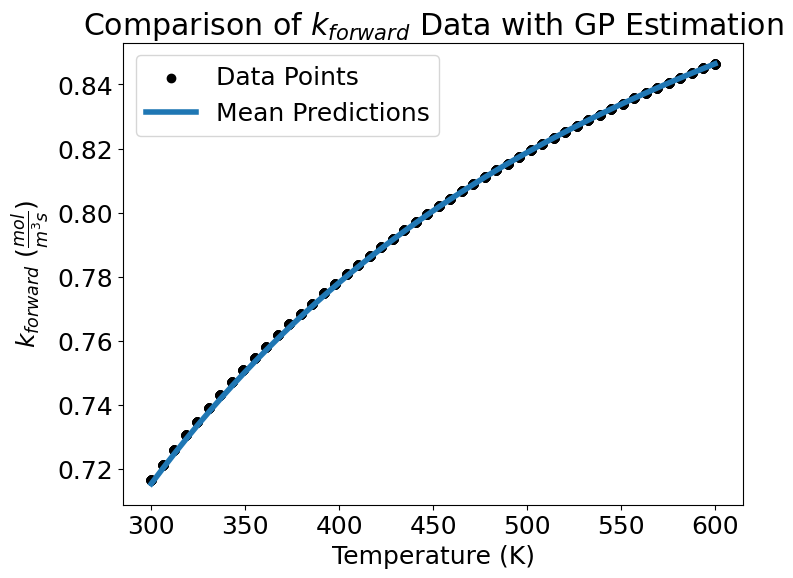

In [3]:
Inv_Temperature = np.array([np.linspace(300,600,50)])**-1
Inv_Temperature_norm = normalize_inputs(Inv_Temperature)

y_mean, y_bounds = model.evaluate(Inv_Temperature_norm.T, GP_number=0, draws = 100, ReturnBounds = 1)

x = inputs[0]
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8, 6))
# Scatter plot
plt.scatter(x**-1, jnp.exp(-100*x), label='Data Points', c='black')

# Line plot for the mean
plt.plot(jnp.flip(jnp.unique(Inv_Temperature**-1)), jnp.exp(-jnp.unique(y_mean)), label='Mean Predictions', linewidth = 4)

# Adding labels and legend
plt.xlabel('Temperature (K)')
plt.ylabel('$k_{forward}$ (' + r'$\frac{mol}{m^3s}$)')
plt.title('Comparison of $k_{forward}$ Data with GP Estimation')
plt.legend()

# Show plot
plt.show()

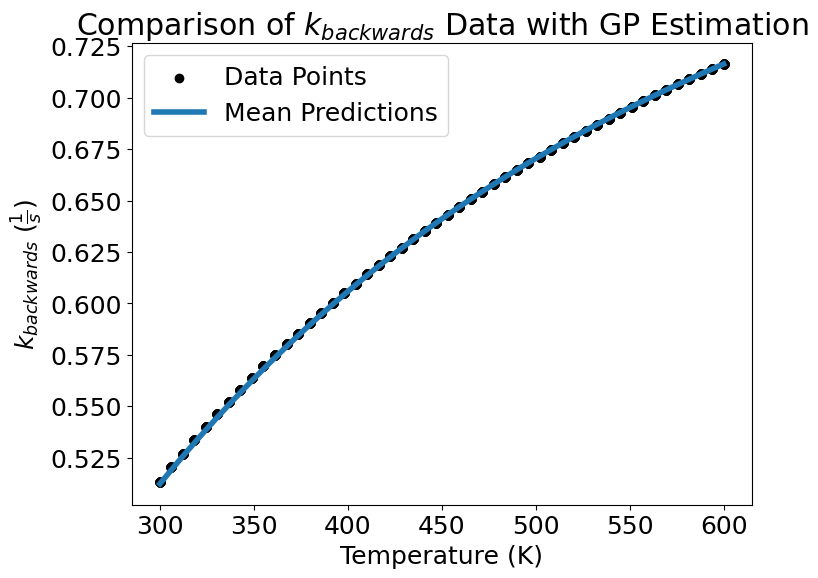

In [4]:
y_mean, y_bounds = model.evaluate(Inv_Temperature_norm.T, GP_number=1, draws = 100, ReturnBounds = 1)

x = inputs[0]
plt.rcParams['font.size'] = 18
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(x**-1, jnp.exp(-200*x), label='Data Points', c='black')

# Line plot for the mean
plt.plot(jnp.flip(jnp.unique(x**-1)), jnp.exp(-jnp.unique(y_mean)), label='Mean Predictions', linewidth = 4)

# Adding labels and legend
plt.xlabel('Temperature (K)')
plt.ylabel('$k_{backwards}$ (' + r'$\frac{1}{s}$)')
plt.title('Comparison of $k_{backwards}$ Data with GP Estimation')
plt.legend()

# Show plot
plt.show()